Using device: cpu
L shape: torch.Size([10000, 10000]), L device: cpu


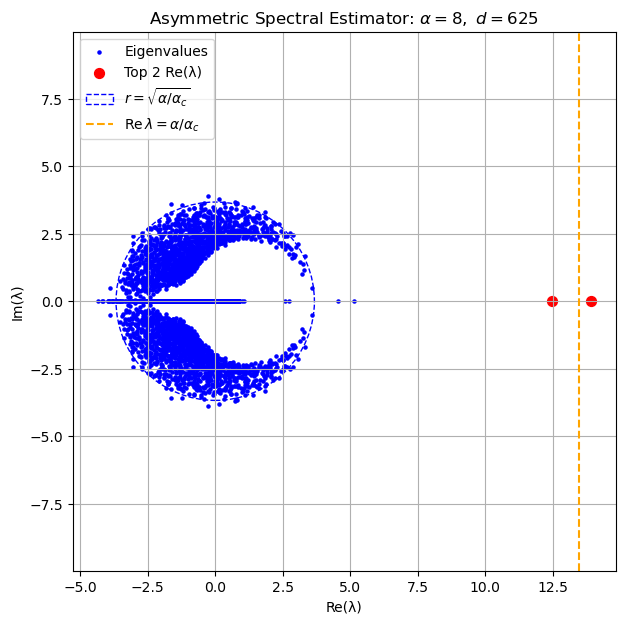

In [ ]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# Configuration
n = 5000       # Number of samples
p = 2          # Subspace dimension
alpha = 8
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Generate input matrix X ∈ ℝ^{n × d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Step 2: Construct signal subspace W* and observations Z = X W*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # Link function: y = z1 * z2

# Step 3: Compute preprocessing function G(y) ∈ ℝ^{n × p × p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # Numerical stability

# Construct G(y): one 2×2 symmetric matrix per sample
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Step 4: Build asymmetric spectral matrix L ∈ ℝ^{np × np}
XXT = X @ X.T                     # Shape: (n, n)
XXT.fill_diagonal_(0.0)           # Zero out the diagonal

# Construct elements of L: (iμ, jν)
A = XXT[:, :, None, None]         # Shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]  # Shape: (1, n, p, p)
L_blocks = A * G_broadcast        # Shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)  # Shape: (np, np)
print(f"L shape: {L.shape}, L device: {L.device}")

# Step 5: Eigendecomposition and spectral visualization
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# Identify top-2 eigenvalues with largest real parts
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# Plot eigenvalue spectrum
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# Theoretical spectral radius and phase transition threshold
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# Figure formatting
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


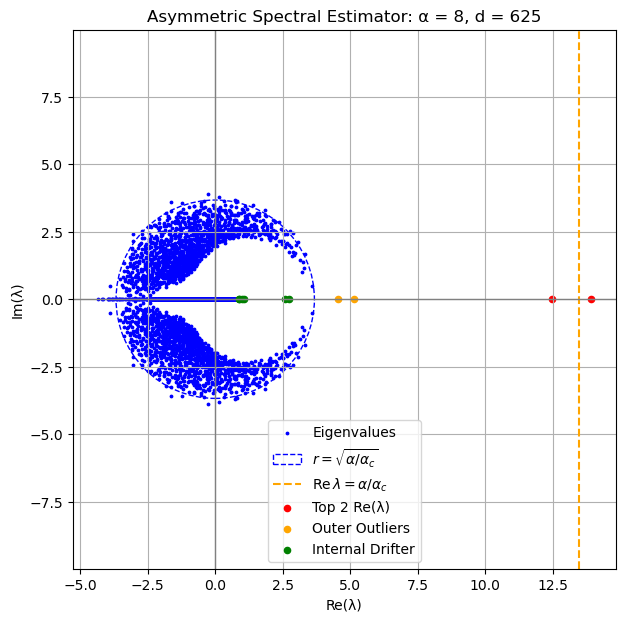

In [ ]:
# Compute decision boundaries
R = np.sqrt(alpha / alpha_c)        # Radius of the theoretical spectral circle
thresh_ext = alpha / alpha_c        # Vertical threshold line on the real axis

# Select real-valued eigenvalues
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Select top-10 eigenvalues with the largest real parts
top10_real_idx = np.argsort(real_parts)[-10:]
top10_real_vals = eigvals_real_only[top10_real_idx]

# Classify eigenvalues: red (top-2), orange (outer region between R and threshold),
# green (internal drifters inside R)
top2_vals = top10_real_vals[-2:]
rest_vals = top10_real_vals[:-2]

orange_vals = []
green_vals = []
for val in rest_vals:
    if R < val.real < thresh_ext:
        orange_vals.append(val)
    elif val.real < R:
        green_vals.append(val)

# Visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

# Dashed boundaries: blue circle & vertical orange threshold
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False,
                    label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--",
            label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# Highlight categories
plt.scatter([z.real for z in top2_vals], [z.imag for z in top2_vals],
            color="red", s=20, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals],
            color="orange", s=20, label="Outer Outliers")
plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals],
            color="green", s=20, label="Internal Drifter")

# Figure formatting
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


In [ ]:

results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_orange = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X)

results_green = []
if green_single_val is not None:
    results_green = generalized_overlap_corrected(
        W_star_np, eigvals_np, eigvecs_np, [green_single_val], "Green", X
    )

# Combine all results into a DataFrame
df_overlap = pd.DataFrame(
    results_red + results_orange + results_green,
    columns=["Label", "Eigenvalue", "Overlap_q"]
)
df_overlap = df_overlap.sort_values("Overlap_q", ascending=False).reset_index(drop=True)

print(df_overlap)


       Label            Eigenvalue  Overlap_q
0     Red2-2  13.902895+ 0.000000j   0.570964
1     Red2-1  13.902895+ 0.000000j   0.570963
2     Red1-1  12.473703+ 0.000000j   0.518925
3     Red1-2  12.473703+ 0.000000j   0.518925
4  Orange2-1   5.134866+ 0.000000j   0.001655
5  Orange2-2   5.134866+ 0.000000j   0.001655
6  Orange1-2   4.549804+ 0.000000j   0.000991
7  Orange1-1   4.549804+ 0.000000j   0.000991
8   Green1-2   2.726897+ 0.000000j   0.000325
9   Green1-1   2.726897+ 0.000000j   0.000325


In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from itertools import combinations
from scipy.linalg import qr

# Define function to compute rank-2 overlap without using Pt numbering
def rank2_overlap_from_labels(W_star, eigvals_np, eigvecs_np, df_result, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')
    X_cpu = X.cpu().numpy().T  # Shape: (d, n)

    v_map = {}  # Map: Label -> eigenvector

    # Extract corresponding eigenvectors for labeled eigenvalues
    for i, row in enumerate(df_result.itertuples()):
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # Shape: (n, 2)
        j = 0 if '1' in label[-3:] else 1  # Select direction based on label suffix
        v_map[label] = V[:, j]

    # Enumerate all unique combinations of eigenvectors
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])  # Shape: (d, 2)
        U, _ = qr(U, mode='economic')  # Orthonormalize estimated subspace
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2  # Squared Frobenius norm
        results.append((f"{id1} + {id2}", q))

    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"]) \
             .sort_values("Rank2_Overlap_q", ascending=False) \
             .reset_index(drop=True)
             
df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_overlap, X)

# Display results
pd.set_option("display.max_rows", None)
print(df_rank2)


               ComboLabel  Rank2_Overlap_q
0         Red2-1 + Red1-1         1.090349
1         Red2-1 + Red1-2         1.090349
2         Red2-2 + Red1-2         1.090349
3         Red2-2 + Red1-1         1.090349
4         Red2-2 + Red2-1         1.069709
5      Red2-2 + Orange2-1         0.574868
6      Red2-2 + Orange2-2         0.574868
7      Red2-1 + Orange2-1         0.574868
8      Red2-1 + Orange2-2         0.574868
9      Red2-2 + Orange1-1         0.572000
10     Red2-2 + Orange1-2         0.572000
11     Red2-1 + Orange1-2         0.572000
12     Red2-1 + Orange1-1         0.572000
13      Red2-2 + Green1-1         0.571448
14      Red2-2 + Green1-2         0.571448
15      Red2-1 + Green1-2         0.571448
16      Red2-1 + Green1-1         0.571448
17        Red1-1 + Red1-2         0.525081
18     Red1-2 + Orange2-1         0.519904
19     Red1-1 + Orange2-1         0.519904
20     Red1-1 + Orange2-2         0.519904
21     Red1-2 + Orange2-2         0.519904
22      Red

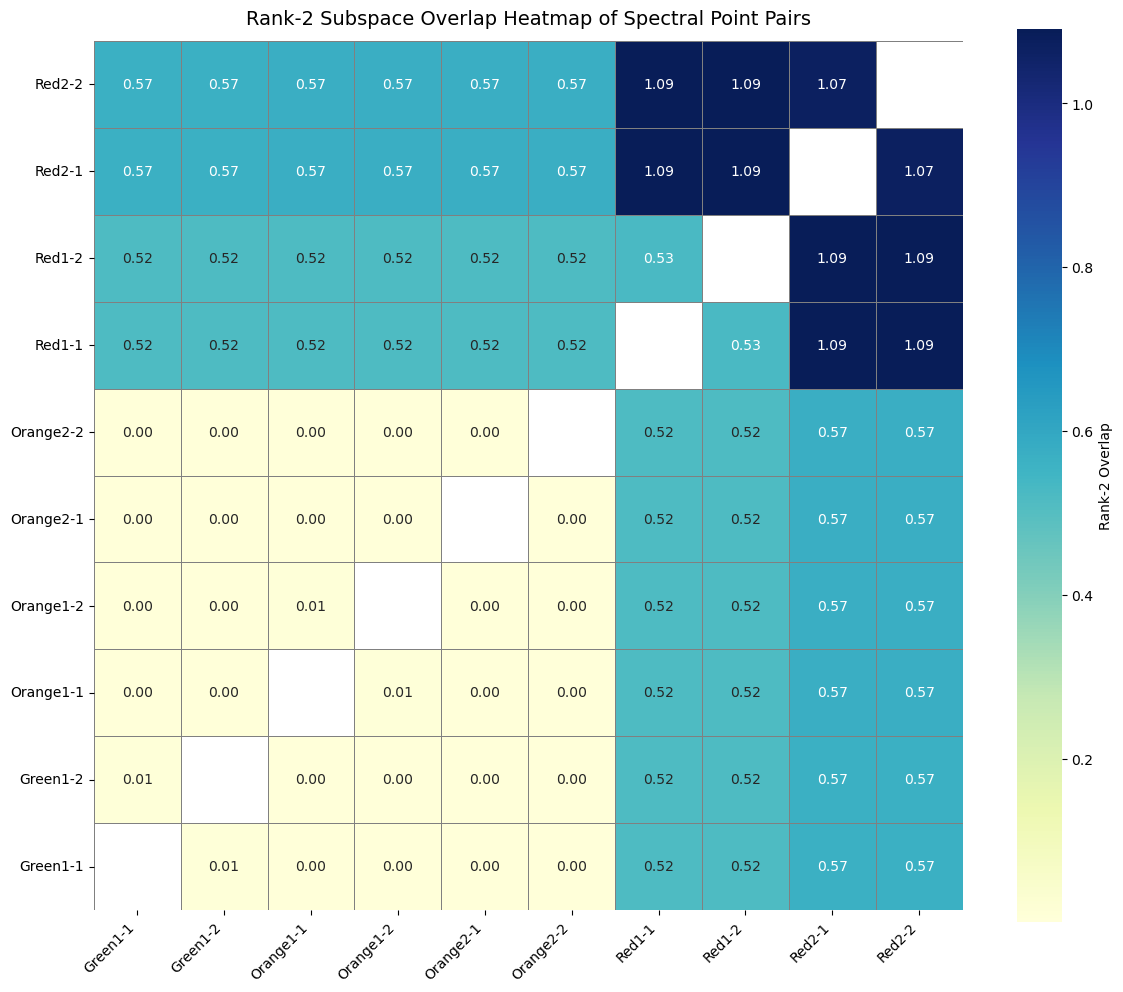

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Extract all unique labels
all_labels = sorted(set(sum([label.split(' + ') for label in df_rank2['ComboLabel']], [])))

# Initialize a symmetric matrix for the heatmap
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

# Fill the matrix with overlap values
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

# Set diagonal to NaN (do not plot self-overlap)
np.fill_diagonal(heatmap_matrix.values, np.nan)

# Identify the top-5 combinations with the highest rank-2 overlap
top5 = df_rank2.nlargest(5, 'Rank2_Overlap_q')

# Plot the heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    heatmap_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu", 
    square=True,
    cbar_kws={'label': 'Rank-2 Overlap'}, 
    linewidths=0.5, 
    linecolor='gray'
)

plt.title("Rank-2 Subspace Overlap Heatmap of Spectral Point Pairs", fontsize=14, pad=12)

# Highlight the top-5 combinations with red rectangles
for _, row in top5.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    i = all_labels.index(a)
    j = all_labels.index(b)
    ax.add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor="red", lw=2))
    ax.add_patch(Rectangle((i, j), 1, 1, fill=False, edgecolor="red", lw=2))

# Set axis labels and layout
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
ax.invert_yaxis()  # Match academic matrix convention
plt.tight_layout()
plt.show()


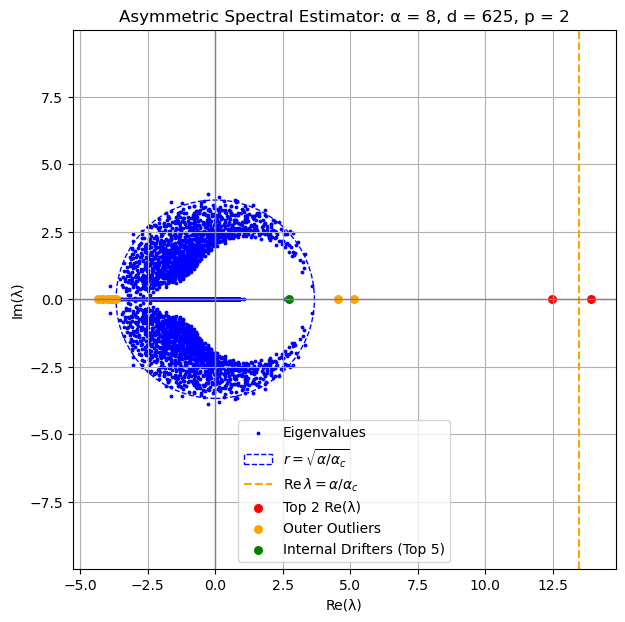

         Type        λ (eigval)  Alignment Score
0       Red-1  13.9029+ 0.0000j           0.7313
1       Red-2  12.4737+ 0.0000j           0.7115
2    Orange-1  -4.3505+ 0.0000j           0.0493
3    Orange-2  -4.1914+ 0.0000j           0.0974
4    Orange-3  -4.1408+ 0.0000j           0.0889
5    Orange-4   5.1349+ 0.0000j           0.0223
6    Orange-5  -3.9697+ 0.0000j           0.0694
7    Orange-6  -3.9749+ 0.0000j           0.0704
8    Orange-7  -3.9295+ 0.0000j           0.0965
9    Orange-8  -3.8951+ 0.0000j           0.0620
10   Orange-9  -3.8254+ 0.0000j           0.0365
11  Orange-10  -3.8091+ 0.0000j           0.0923
12  Orange-11  -3.7689+ 0.0000j           0.1706
13  Orange-12  -3.7310+ 0.0000j           0.0169
14  Orange-13  -3.6708+ 0.0000j           0.0354
15  Orange-14   4.5498+ 0.0000j           0.0426
16    Green-1   2.7269+ 0.0000j           0.0277


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd

# Alignment score between estimated and true subspaces
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace extraction and alignment from a single eigenvalue
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Eigendecomposition and data extraction
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

# Parameters
R = np.sqrt(alpha / alpha_c)          # Spectral radius
thresh_ext = alpha / alpha_c          # Real-axis threshold

# Keep real eigenvalues only
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]

# Red: top-2 eigenvalues by real part
red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]

# Orange: outside the circle and not in red
orange_candidates = [z for z in eigvals_real_only if abs(z) > R]
orange_vals = [z for z in orange_candidates if z not in red_vals]

# Green: inside the circle, top-2 by real part
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# Visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# Red points
plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals],
            color="red", s=30, label="Top 2 Re(λ)")

# Orange points
if orange_vals:
    plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals],
                color="orange", s=30, label="Outer Outliers")

# Green points
if green_vals:
    plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals],
                color="green", s=30, label="Internal Drifters (Top 5)")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Alignment analysis
results = []

for i, val in enumerate(red_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Red-{i+1}"))

for i, val in enumerate(orange_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Orange-{i+1}"))

for i, val in enumerate(green_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Green-{i+1}"))

# Tabular output
df = pd.DataFrame(results, columns=["Type", "λ (eigval)", "Alignment Score"])
pd.set_option("display.precision", 4)
print(df)


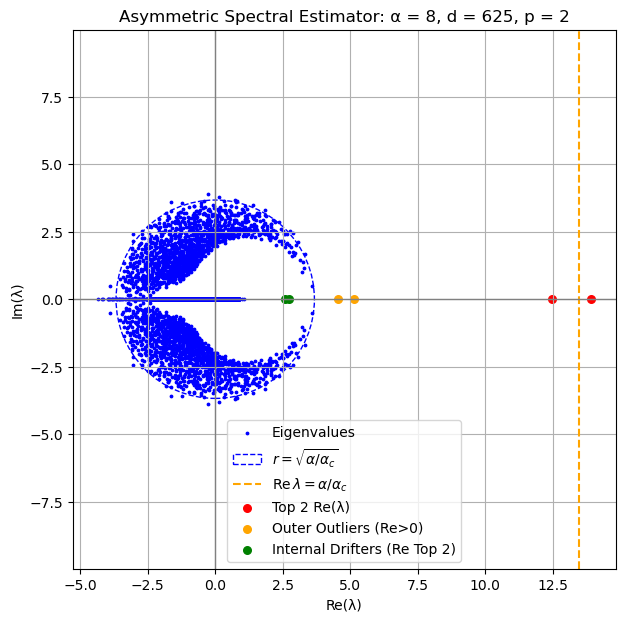

       Type        λ (eigval)  Alignment Score
0     Red-1  13.9029+ 0.0000j           0.7313
1     Red-2  12.4737+ 0.0000j           0.7115
2  Orange-1   5.1349+ 0.0000j           0.0223
3  Orange-2   4.5498+ 0.0000j           0.0426
4   Green-1   2.7269+ 0.0000j           0.0277
5   Green-2   2.5957+ 0.0000j           0.0427


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd

# Alignment score between estimated and true subspaces
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace extraction and alignment from a single eigenvalue
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Eigendecomposition and data extraction
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

# Parameters
R = np.sqrt(alpha / alpha_c)          # Spectral radius
thresh_ext = alpha / alpha_c          # Real-axis threshold

# Real-eigenvalue filter
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]

# Red: top two eigenvalues by real part
red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]

# Orange: outside the circle, positive real part, excluding red
orange_candidates = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
orange_vals = [z for z in orange_candidates if z not in red_vals]

# Green: on the real axis and inside the circle, top two by real part
green_candidates = [z for z in eigvals_np
                    if np.isclose(z.imag, 0.0, atol=1e-6) and abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# Spectrum visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# Red points
plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals],
            color="red", s=30, label="Top 2 Re(λ)")

# Orange points
if orange_vals:
    plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals],
                color="orange", s=30, label="Outer Outliers (Re>0)")

# Green points
if green_vals:
    plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals],
                color="green", s=30, label="Internal Drifters (Re Top 2)")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Alignment analysis
results = []

for i, val in enumerate(red_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Red-{i+1}"))

for i, val in enumerate(orange_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Orange-{i+1}"))

for i, val in enumerate(green_vals):
    results.append(extract_W_from_eigenvectors(eigvecs_np, val, X, W_star, p=2, label=f"Green-{i+1}"))

# Tabular output
df = pd.DataFrame(results, columns=["Type", "λ (eigval)", "Alignment Score"])
pd.set_option("display.precision", 4)
print(df)


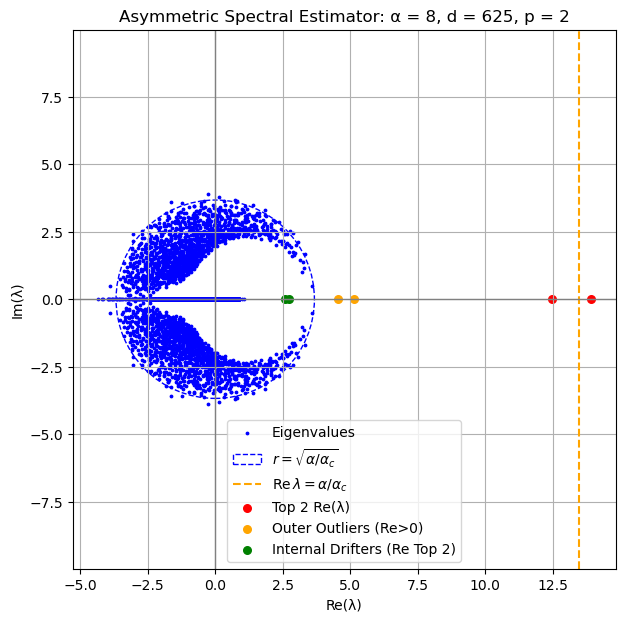

                 Type                λ1                λ2  Alignment Score
0   Red-(13.90,12.47)  13.9029+ 0.0000j  12.4737+ 0.0000j           0.7313
2   Green-(2.73,2.60)   2.7269+ 0.0000j   2.5957+ 0.0000j           0.0277
1  Orange-(5.13,4.55)   5.1349+ 0.0000j   4.5498+ 0.0000j           0.0223


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd
from itertools import combinations

# Alignment score computation
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace extraction and alignment for eigenvalue pairs
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]

    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# Eigen-decomposition
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

# Eigenvalue classification
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c

real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]

red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]
orange_candidates = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
orange_vals = [z for z in orange_candidates if z not in red_vals]
green_candidates = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6) and abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# Spectral visualization (optional)
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals], color="orange", s=30, label="Outer Outliers (Re>0)")
plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals], color="green", s=30, label="Internal Drifters (Re Top 2)")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Alignment score analysis (pairwise combinations)
results = []
type_groups = [("Red", red_vals), ("Orange", orange_vals), ("Green", green_vals)]

for group_name, eigval_list in type_groups:
    for (z1, z2) in combinations(eigval_list, 2):
        label = f"{group_name}-({z1.real:.2f},{z2.real:.2f})"
        result = extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=label)
        results.append(result)

# Output DataFrame
df = pd.DataFrame(results, columns=["Type", "λ1", "λ2", "Alignment Score"])
pd.set_option("display.precision", 4)
print(df.sort_values(by="Alignment Score", ascending=False))


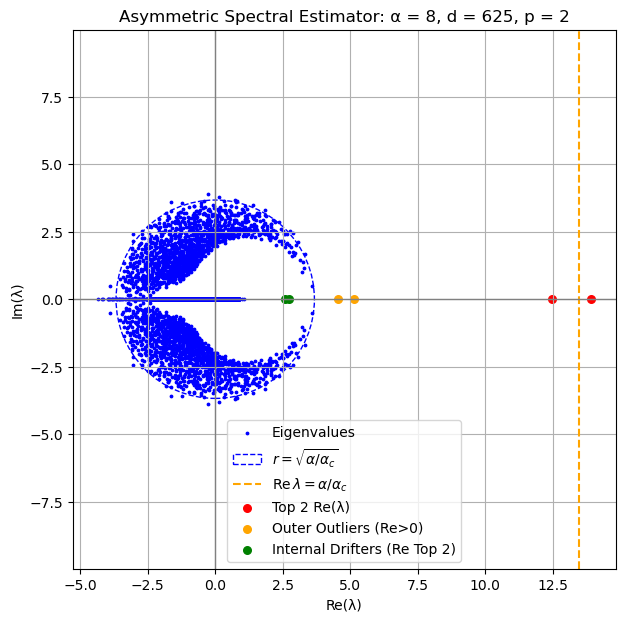

                        Type                λ1                λ2  \
0       Red-Red(13.90,12.47)  13.9029+ 0.0000j  12.4737+ 0.0000j   
1     Red-Orange(13.90,5.13)  13.9029+ 0.0000j   5.1349+ 0.0000j   
2     Red-Orange(13.90,4.55)  13.9029+ 0.0000j   4.5498+ 0.0000j   
3      Red-Green(13.90,2.73)  13.9029+ 0.0000j   2.7269+ 0.0000j   
4      Red-Green(13.90,2.60)  13.9029+ 0.0000j   2.5957+ 0.0000j   
5     Red-Orange(12.47,5.13)  12.4737+ 0.0000j   5.1349+ 0.0000j   
6     Red-Orange(12.47,4.55)  12.4737+ 0.0000j   4.5498+ 0.0000j   
7      Red-Green(12.47,2.73)  12.4737+ 0.0000j   2.7269+ 0.0000j   
8      Red-Green(12.47,2.60)  12.4737+ 0.0000j   2.5957+ 0.0000j   
12   Orange-Green(4.55,2.73)   4.5498+ 0.0000j   2.7269+ 0.0000j   
13   Orange-Green(4.55,2.60)   4.5498+ 0.0000j   2.5957+ 0.0000j   
14    Green-Green(2.73,2.60)   2.7269+ 0.0000j   2.5957+ 0.0000j   
9   Orange-Orange(5.13,4.55)   5.1349+ 0.0000j   4.5498+ 0.0000j   
10   Orange-Green(5.13,2.73)   5.1349+ 0.0000j  

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr
import pandas as pd
from itertools import combinations

# Alignment score computation
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace extraction and alignment for eigenvalue pairs
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]

    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# Eigendecomposition
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()
d = W_star_np.shape[0]

# Eigenvalue classification
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c

real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]

red_vals = sorted(eigvals_real_only, key=lambda z: z.real, reverse=True)[:2]
orange_candidates = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
orange_vals = [z for z in orange_candidates if z not in red_vals]
green_candidates = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6) and abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# Spectrum visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

plt.scatter([z.real for z in red_vals], [z.imag for z in red_vals], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for z in orange_vals], [z.imag for z in orange_vals], color="orange", s=30, label="Outer Outliers (Re>0)")
plt.scatter([z.real for z in green_vals], [z.imag for z in green_vals], color="green", s=30, label="Internal Drifters (Re Top 2)")

plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Pairwise alignment score analysis
highlight_vals = [("Red", z) for z in red_vals] + \
                 [("Orange", z) for z in orange_vals] + \
                 [("Green", z) for z in green_vals]

results = []
for (label1, z1), (label2, z2) in combinations(highlight_vals, 2):
    pair_label = f"{label1}-{label2}({z1.real:.2f},{z2.real:.2f})"
    result = extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label)
    results.append(result)

# Tabular output
df = pd.DataFrame(results, columns=["Type", "λ1", "λ2", "Alignment Score"])
pd.set_option("display.precision", 4)
print(df.sort_values(by="Alignment Score", ascending=False))


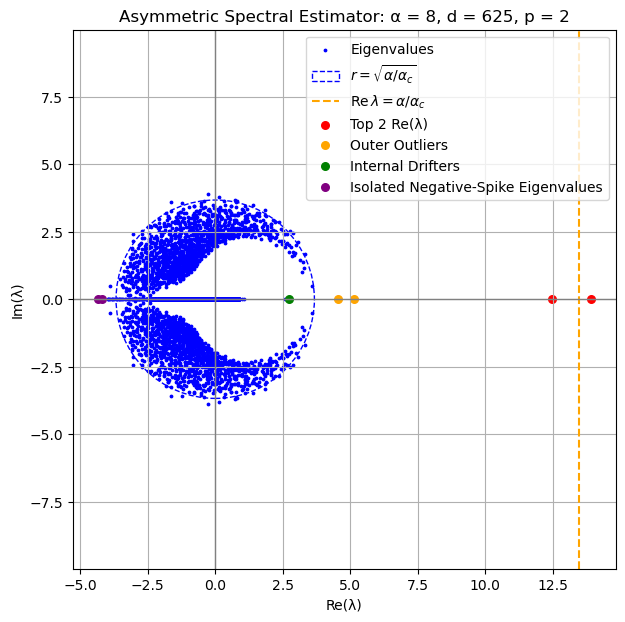


=== Rank-1 Overlap Summary ===
        Label  Overlap_q
0      Red1-2   0.570964
1      Red1-1   0.570963
2      Red2-1   0.518925
3      Red2-2   0.518925
4   Purple2-1   0.011175
5   Purple2-2   0.011175
6   Purple1-1   0.002028
7   Purple1-2   0.002028
8   Orange1-1   0.001655
9   Orange1-2   0.001655
10  Orange2-2   0.000991
11  Orange2-1   0.000991
12   Green1-2   0.000325
13   Green1-1   0.000325
Mean: 0.1580 | Max: 0.5710 | Min: 0.0003

===  Rank-2 Overlap Combinations ===
              ComboLabel  Rank2_Overlap_q
0        Red1-1 + Red2-1         1.090349
1        Red1-2 + Red2-1         1.090349
2        Red1-2 + Red2-2         1.090349
3        Red1-1 + Red2-2         1.090349
4        Red2-1 + Red2-2         1.023964
..                   ...              ...
86  Purple1-2 + Green1-1         0.002328
87  Orange1-2 + Green1-2         0.002175
88  Orange1-2 + Green1-1         0.002175
89  Orange1-1 + Green1-1         0.002175
90  Orange1-1 + Green1-2         0.002175

[91 rows 

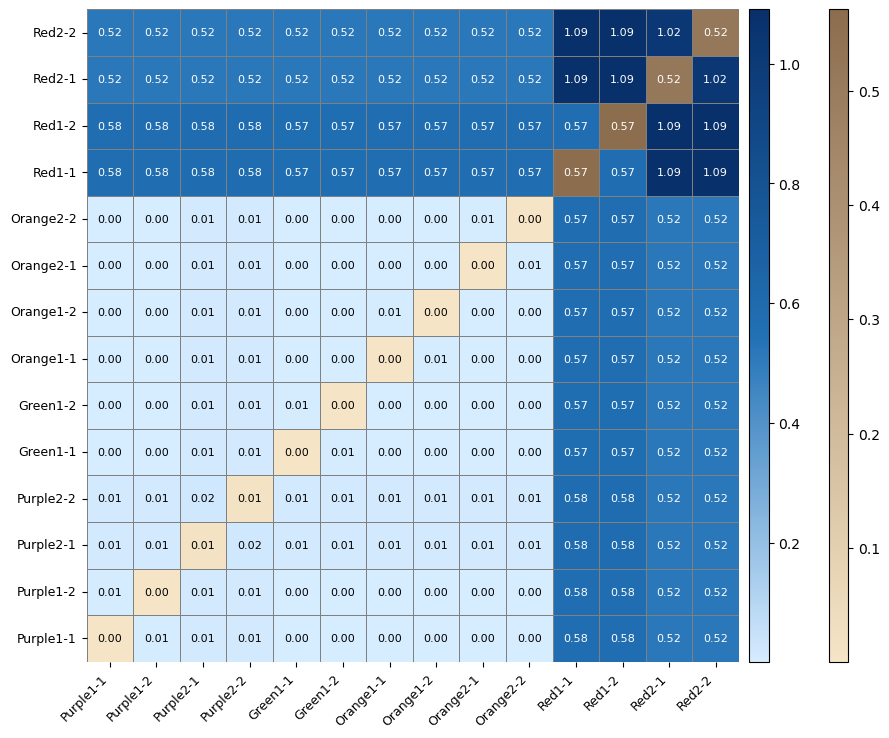

In [ ]:
# Dependencies
import os, random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.linalg import qr
from scipy.special import kv as besselk
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

# Utility functions
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_text_color(value, cmap, vmin, vmax):
    rgba = cmap((value - vmin) / (vmax - vmin))
    r, g, b = to_rgb(rgba[:3])
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'black' if luminance > 0.5 else 'white'

def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')  # orthogonalize W*
    X_cpu = X.cpu().numpy().T
    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)
        U = X_cpu @ V
        for j in range(2):
            u = U[:, j]
            u_hat = u / np.linalg.norm(u)
            q = np.linalg.norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

def rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X):
    results = []
    W_orth, _ = qr(W_star_np, mode='economic')  # orthogonalize ground-truth subspace
    X_cpu = X.cpu().numpy().T
    v_map = {}
    for row in df_result.itertuples():
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx].reshape(-1, 2)
        j = 0 if '1' in label[-3:] else 1  # select direction by label suffix
        v_map[label] = v_hat[:, j]
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])
        U, _ = qr(U, mode='economic')  # orthonormal basis
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2
        results.append((f"{id1} + {id2}", q))
    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"]) \
             .sort_values("Rank2_Overlap_q", ascending=False).reset_index(drop=True)

# Configuration
set_seed(42)
n, p = 5000, 2

alpha = 8
alpha_c = 0.59375
R = np.sqrt(alpha / alpha_c)        # spectral radius for the reference circle
thresh_ext = alpha / alpha_c        # vertical threshold on the real axis

d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data generation
X = torch.randn(n, d, device=device) / np.sqrt(d)
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2

# Preprocessing matrix G(y)
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1, K0 = besselk(1, abs_y), besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Spectral matrix construction
XXT = X @ X.T
XXT.fill_diagonal_(0.0)
A = XXT[:, :, None, None]
G_broadcast = G_y[None, :, :, :]
L_blocks = A * G_broadcast
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

# Eigendecomposition and eigenvalue grouping
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()

R = np.sqrt(alpha / alpha_c)
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real = eigvals_np[real_mask]

red_vals = sorted(eigvals_real, key=lambda z: z.real, reverse=True)[:2]  # top-2 by Re(λ)
orange_vals = [z for z in eigvals_real if abs(z) > R and z.real > 0 and z not in red_vals]
green_vals = sorted([z for z in eigvals_real if abs(z) <= R and z.real > 0], key=lambda z: z.real, reverse=True)[:1]
purple_vals = [z for z in eigvals_real if z.real < 0 and abs(z) > R][:2]

# Spectrum plot
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals)]
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals)]
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals)]
purple_labels = [(f"Purple{i+1}", z) for i, z in enumerate(purple_vals)]

plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color="green", s=30, label="Internal Drifters")
plt.scatter([z.real for _, z in purple_labels], [z.imag for _, z in purple_labels], color="purple", s=30, label="Isolated Negative-Spike Eigenvalues")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Rank-1 overlap summary
df_result = pd.DataFrame(
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, orange_vals, "Orange", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X) +
    generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, purple_vals, "Purple", X),
    columns=["Label", "Eigenvalue", "Overlap_q"]
).sort_values("Overlap_q", ascending=False).reset_index(drop=True)

print("\nRank-1 Overlap Summary")
print(df_result[["Label", "Overlap_q"]])
print(f"Mean: {df_result['Overlap_q'].mean():.4f} | Max: {df_result['Overlap_q'].max():.4f} | Min: {df_result['Overlap_q'].min():.4f}")

# Rank-2 overlap combinations
df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X)
print("\nRank-2 Overlap Combinations")
print(df_rank2)

# Heatmap construction
labels_rank1 = set(df_result["Label"])
labels_rank2 = set()
for combo in df_rank2["ComboLabel"]:
    a, b = combo.split(" + ")
    labels_rank2.update([a, b])
all_labels = sorted(labels_rank1.union(labels_rank2))
color_order = ["Purple", "Green", "Orange", "Red"]
sorted_labels = []
for color in color_order:
    sorted_labels.extend(sorted([l for l in all_labels if color.lower() in l.lower()]))

heatmap_matrix = pd.DataFrame(np.nan, index=sorted_labels, columns=sorted_labels)
for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']
for _, row in df_result.iterrows():
    heatmap_matrix.loc[row['Label'], row['Label']] = row['Overlap_q']

# Colormaps and ranges
cmap_rank2 = LinearSegmentedColormap.from_list("blue_grad", ["#D6ECFF", "#2171B5", "#08306B"])
cmap_rank1 = LinearSegmentedColormap.from_list("brown_grad", ["#F5E5C6", "#8C6D4E"])
rank1_vals = heatmap_matrix.values[np.eye(len(sorted_labels), dtype=bool)]
rank2_vals = heatmap_matrix.values[~np.eye(len(sorted_labels), dtype=bool)]
rank1_min, rank1_max = np.nanmin(rank1_vals), np.nanmax(rank1_vals)
rank2_min, rank2_max = np.nanmin(rank2_vals), np.nanmax(rank2_vals)

# Plot heatmap overlays (rank-2 off-diagonal, rank-1 diagonal)
fig, ax = plt.subplots(figsize=(9, 8))
mask_rank1 = ~np.eye(len(sorted_labels), dtype=bool)
mask_rank2 = np.eye(len(sorted_labels), dtype=bool)

sns.heatmap(heatmap_matrix, mask=mask_rank2, cmap=cmap_rank2, annot=False, square=True,
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax)
sns.heatmap(heatmap_matrix, mask=mask_rank1, cmap=cmap_rank1, annot=False, square=True,
            cbar=False, linewidths=0.5, linecolor='gray', ax=ax)

# Value annotations
for i in range(len(sorted_labels)):
    for j in range(len(sorted_labels)):
        value = heatmap_matrix.iloc[i, j]
        if pd.isna(value):
            continue
        is_rank1 = (i == j)
        cmap = cmap_rank1 if is_rank1 else cmap_rank2
        vmin = rank1_min if is_rank1 else rank2_min


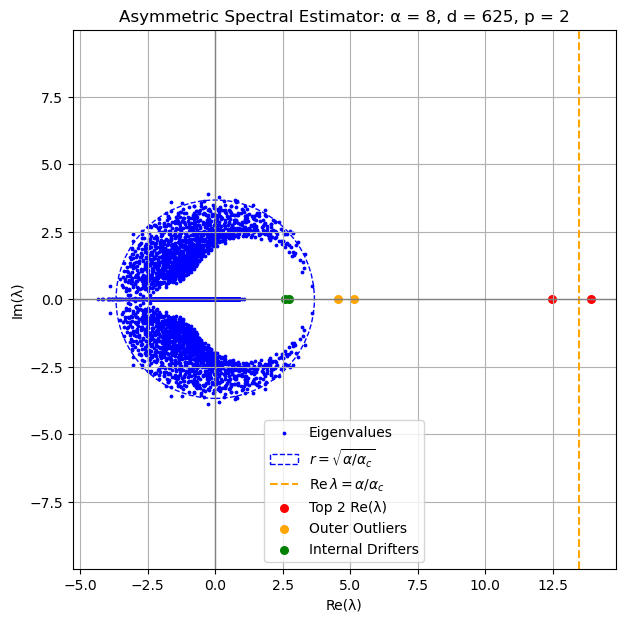


=== Alignment Score for Individual Eigenvalues ===
      Type                     λ  Alignment Score
0   Green1   2.726897+ 0.000000j         0.027697
1   Green2   2.595683+ 0.000000j         0.042665
2  Orange1   5.134866+ 0.000000j         0.022300
3  Orange2   4.549804+ 0.000000j         0.042596
4     Red1  13.902895+ 0.000000j         0.731295
5     Red2  12.473703+ 0.000000j         0.711489

=== Alignment Score for Pairs of Eigenvalues ===
               Pair                    λ1                    λ2  \
14        Red1-Red2  13.902895+ 0.000000j  12.473703+ 0.000000j   
5    Green2-Orange1   2.595683+ 0.000000j   5.134866+ 0.000000j   
6    Green2-Orange2   2.595683+ 0.000000j   4.549804+ 0.000000j   
7       Green2-Red1   2.595683+ 0.000000j  13.902895+ 0.000000j   
8       Green2-Red2   2.595683+ 0.000000j  12.473703+ 0.000000j   
12     Orange2-Red1   4.549804+ 0.000000j  13.902895+ 0.000000j   
13     Orange2-Red2   4.549804+ 0.000000j  12.473703+ 0.000000j   
0     Green1

/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_2864/850667457.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


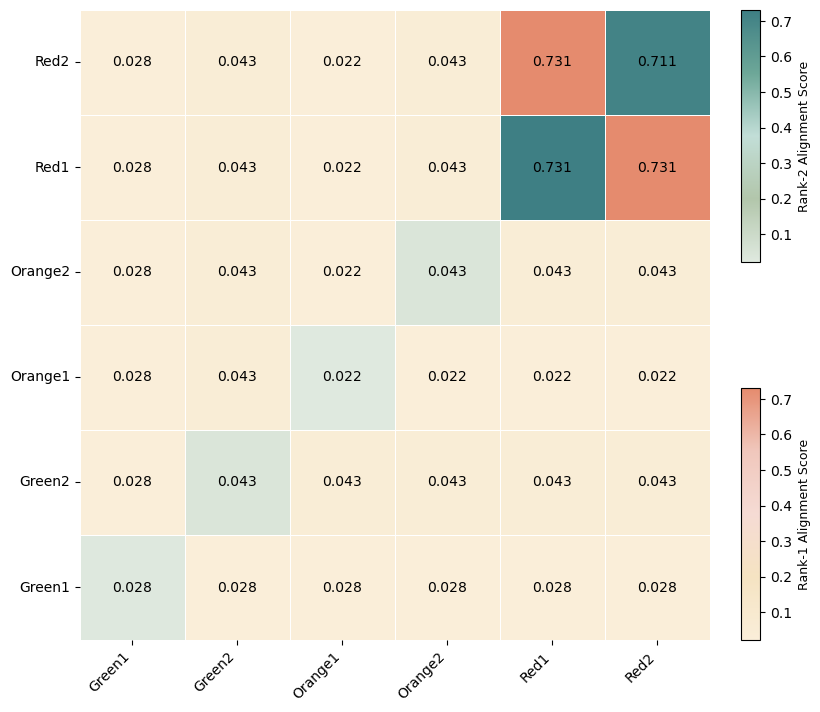

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
from scipy.linalg import qr
from itertools import combinations

# Alignment score between estimated and true subspaces
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# Subspace extraction from a single eigenvalue and alignment evaluation
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# Subspace extraction from an eigenvalue pair and alignment evaluation
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]
    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# Eigendecomposition
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# Eigenvalue categorization (red / orange / green)

# Base quantities
R = np.sqrt(alpha / alpha_c)  # radius threshold
eigvals_np = eigvals.cpu().numpy()
eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]  # real-spectrum subset

# Red: top two real parts outside the radius and with positive real part
outside_radius = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
red_vals = sorted(outside_radius, key=lambda z: z.real, reverse=True)[:2]

# Orange: remaining positive-real eigenvalues outside the radius, excluding red
orange_vals = [z for z in outside_radius if z not in red_vals]

# Green: inside the radius on the real axis, top-n by real part (n=2 here)
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]

# Consistent labeling (within each color, larger real part gets index 1)
green_vals_sorted = sorted(green_vals, key=lambda z: z.real, reverse=True)
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals_sorted)]

orange_vals_sorted = sorted(orange_vals, key=lambda z: z.real, reverse=True)
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals_sorted)]

red_vals_sorted = sorted(red_vals, key=lambda z: z.real, reverse=True)
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals_sorted)]

# Merge labels in plotting order
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]  # e.g., Green1 Green2 Orange1 Orange2 Red1 Red2

# One-shot spectral plot
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels],   [z.imag for _, z in red_labels],   color="red",   s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels],[z.imag for _, z in orange_labels], color="orange",s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color="green", s=30, label="Internal Drifters")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# Alignment scores for individual eigenvalues
results_single = []
for label, z in all_labels:
    results_single.append(extract_W_from_eigenvectors(eigvecs_np, z, X, W_star, p=2, label=label))
df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\nAlignment Score for Individual Eigenvalues")
print(df_single)

# Alignment scores for eigenvalue pairs
results_pair = []
for (label1, z1), (label2, z2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    results_pair.append(extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label))
df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\nAlignment Score for Pairs of Eigenvalues")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# Heatmap construction

# Build heatmap data container
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# Fill diagonal with rank-1 scores
for _, row in df_single.iterrows():
    label = row["Type"]
    score = row["Alignment Score"]
    heatmap_df.loc[label, label] = score

# Fill off-diagonals with pairwise (rank-2) scores
for _, row in df_pair.iterrows():
    label1, label2 = row["Pair"].split("-")
    score = row["Alignment Score"]
    heatmap_df.loc[label1, label2] = score
    heatmap_df.loc[label2, label1] = score  # symmetry

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Colormaps
diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)

# Masks
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)
mask_offdiag = ~mask_diag

# Range
vmin = np.nanmin(heatmap_df.values)
vmax = np.nanmax(heatmap_df.values)

# Figure
fig, ax = plt.subplots(figsize=(8, 7))

# Off-diagonal layer (rank-2)
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# Compact colorbar for rank-2
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm1 = plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
cbar1.set_label("Rank-2 Alignment Score", fontsize=9)

# Diagonal layer (rank-1)
sns.heatmap(heatmap_df, mask=mask_offdiag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# Second colorbar for rank-1
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right',
                      bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm2 = plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar2 = fig.colorbar(sm2, cax=cbar_ax2)
cbar2.set_label("Rank-1 Alignment Score", fontsize=9)

# Annotate values
for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=10)

# Aesthetics
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()

plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)
plt.show()
